# Feature Extraction: Edges

# Table of Contents:


1.   Setup
2.   Load Data
3.   Quick EDA
4.   Feature Extraction: Edge Detection
5.   PCA
6.   Predictive Power
7.   TSNE (WIP)
8.   K Means (WIP)


## Setup

In [1]:
!pip install webdataset

In [2]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv

from skimage import feature
from skimage import data, exposure
from skimage import filters

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import seaborn as sns



In [3]:
# paths
root = '/content/drive/My Drive/2024-12-09 281_Final-main/'
data_folder = f'{root}/data'
feature_data_folder = f'{root}/feature_data/edges'

# Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# #alternate paths
# root = '.'
# data_folder = f'{root}/data'
# feature_data_folder = f'{root}/feature_data/edges/'

## Load Data

In [5]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns:
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [6]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

7


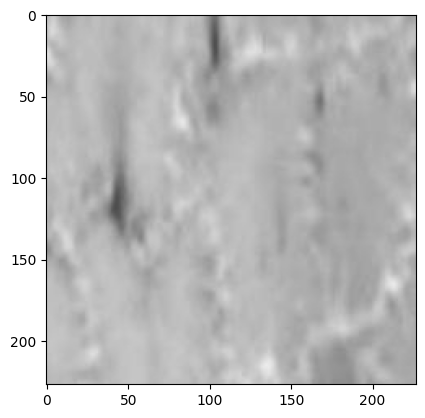

In [7]:
print(train_labels[0])
plt.imshow(train_images[0])

In [8]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8252, 227, 227, 3)
Shape of labels: (8252,)


## Quick EDA

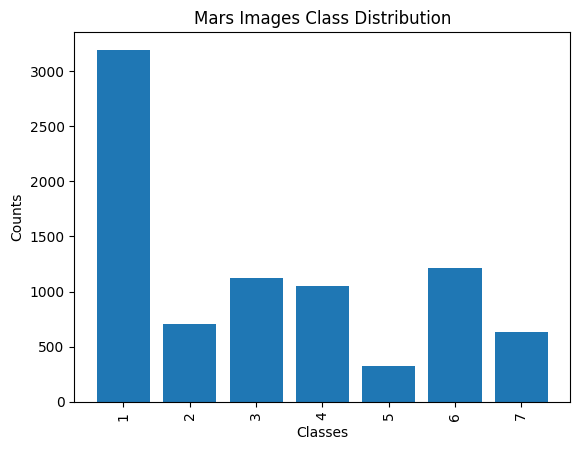

In [9]:
unique, counts = np.unique(train_labels, return_counts=True)
class_dict = dict(zip(unique, counts))
#plot
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()), rotation = 'vertical')
plt.title('Mars Images Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

# View Class Samples

In [10]:
def plot_class_samples(images: list, labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,3))

    for i, (label, image) in enumerate(zip(labels, images)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('One Image For Each Class')
    plt.show()

def load_class_samples(images: list, labels: list) -> tuple:
    label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
    unique_labels = np.unique(labels)

    sample_images = []
    sample_labels = []

    for value in unique_labels:
        label = label_names[value - 1]
        index = int(np.where(train_labels==value)[0][0])

        sample_labels.append(label)
        sample_images.append(images[index])

    return sample_images, sample_labels

In [11]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

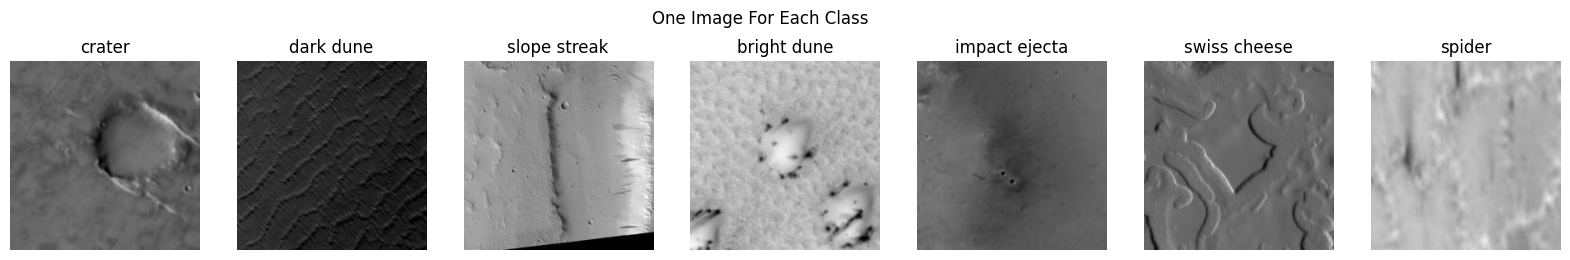

In [12]:
plot_class_samples(sample_imgs, sample_lbls)

## Feature Extraction: Edge Detection


In [13]:
# Switched to cv2
 #apply to all, uses canny edge detection
# def extract_edges_canny(img_dataset, sigma = 1.0):
#     """
#     Apply Canny edge detection for feature extraction to all images
#     args: img_dataset (training / val / testing dataset)
#     returns: img_dataset_canny_edges (dataset of canny edges)

#     """
#     img_dataset_canny_edges = []
#     edge_features = []
#     for img in img_dataset:
#         canny_edges_image = feature.canny(img[:,:,0], sigma = sigma)
#         img_dataset_canny_edges.append(canny_edges_image)
#         #full true false edges - regular
#         edge_features.append(canny_edges_image.ravel())
#         #look at counts of edges instead of where edges are
#         #edge_features.append(len(np.where(canny_edges_image.ravel() == True)[0]))


#     img_dataset_canny_edges = np.array(img_dataset_canny_edges)
#     edge_features = np.array(edge_features)
#     return img_dataset_canny_edges, edge_features

In [14]:
def extract_edge_lengths(img_dataset):
    total_features = []
    for img in img_dataset:
        img = img[:,:,0]
        edges = cv.Canny(img, threshold1 = 100, threshold2=200)
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        contour_lengths = [cv.arcLength(contour, closed=False) for contour in contours]
        #agg features
        total_length = sum(contour_lengths)
        mean_length = np.mean(contour_lengths) if contour_lengths else 0
        std_length = np.std(contour_lengths) if contour_lengths else 0
        num_contours = len(contours)
        features = np.array([total_length, mean_length, std_length, num_contours])
        total_features.append(features.flatten())
    return np.array(total_features)

In [15]:
def extract_edge_density(img_dataset):
    total_features = []
    for img in img_dataset:
        img = img[:,:,0]
        edges = cv.Canny(img, threshold1 = 100, threshold2=200)
        num_edge_pixels = np.sum(edges > 0)
        total_pixels = edges.size
        edge_density = num_edge_pixels / total_pixels
        total_features.append(edge_density)
    return np.array(total_features)

In [16]:
def extract_edge_coords(img_dataset):
    total_features = []
    for img in img_dataset:
        img = img[:,:,0]
        edges = cv.Canny(img, threshold1=100, threshold2=200)
        y_coords, x_coords = np.where(edges > 0)
        coordinates = np.column_stack((x_coords, y_coords))

        desired_length = 1000
        if len(coordinates) > desired_length:
            # Randomly sample to reduce
            indices = np.random.choice(len(coordinates), desired_length, replace=False)
            sampled_coordinates = coordinates[indices]
        elif len(coordinates) < desired_length:
            # Pad with zeros to increase
            padding = np.zeros((desired_length - len(coordinates), 2), dtype=coordinates.dtype)
            sampled_coordinates = np.vstack((coordinates, padding))
        else:
            # Exact match
            sampled_coordinates = coordinates
        total_features.append(sampled_coordinates.flatten())
    return total_features

In [17]:
def extract_combined_features_edges(img_dataset):
    """
    Extract and combine various edge-related features for all images in the dataset.
    args:
    - img_dataset: The dataset of images (grayscale).
    returns:
    - all_features (numpy array): A matrix of combined features for each image in the dataset.
    """
    # Extract features using the predefined functions
    edge_lengths = extract_edge_lengths(img_dataset)
    edge_density = extract_edge_density(img_dataset)
    edge_coords = extract_edge_coords(img_dataset)

    # Combine all features for each image
    all_features = np.concatenate([
        edge_lengths,             # Contour length statistics
        edge_density[:, None],   # Edge density (reshaped to be a column vector)
        edge_coords               # Edge coordinates (flattened)
    ], axis=1)

    # Return the combined features matrix
    return np.array(all_features)


In [18]:
canny_features_train = extract_combined_features_edges(train_images)

In [19]:
canny_features_val = extract_combined_features_edges(val_images)

In [20]:
canny_features_test = extract_combined_features_edges(test_images)

In [21]:
np.save(f'{feature_data_folder}/train_images_canny_edges.npy', canny_features_train)
np.save(f'{feature_data_folder}/val_images_canny_edges.npy', canny_features_val)
np.save(f'{feature_data_folder}/test_images_canny_edges.npy', canny_features_test)


# Load features from saved edges npy

In [22]:
canny_features_train = np.load(f'{feature_data_folder}/train_images_canny_edges.npy')
canny_features_val = np.load(f'{feature_data_folder}/val_images_canny_edges.npy')
canny_features_test = np.load(f'{feature_data_folder}/test_images_canny_edges.npy')

# Data:
# edge_lengths contains the contour length statistics for each image.
# edge_density is a single value for each image, representing the edge density.
# edge_coords contains the flattened edge pixel coordinates for each image.


# Exploration and Visualization

In [23]:
# Set X and Y
X_train = canny_features_train
T_train = train_labels
X_val = canny_features_val
y_val = val_labels
X_test = canny_features_test
y_test = test_labels

In [24]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train data
X_val_scaled = scaler.transform(X_val)  # Apply the same scaling to validation data
X_test_scaled = scaler.transform(X_test)  # Apply the same scaling to test data



In [25]:
# Apply PCA for Dimensionality Reduction
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled) # Fit on train data
X_val_pca = pca.transform(X_val_scaled)  # Apply the same transformation to validation data
X_test_pca = pca.transform(X_test_scaled)  # Apply the same transformation to test data

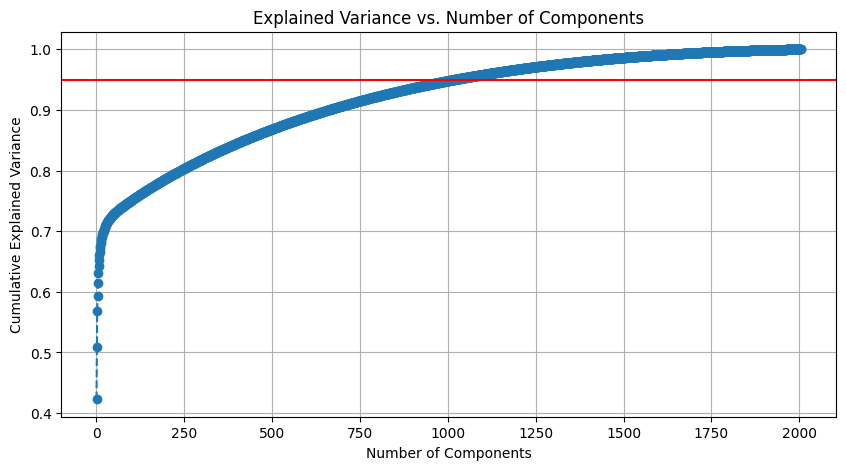

In [26]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
# draw a line at 95% of explained variance
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [32]:
# Apply PCA for Dimensionality Reduction
pca_1000 = PCA(n_components=1000)
X_train_pca = pca_1000.fit_transform(X_train_scaled) # Fit on train data
X_val_pca = pca_1000.transform(X_val_scaled)  # Apply the same transformation to validation data
X_test_pca = pca_1000.transform(X_test_scaled)  # Apply the same transformation to test data

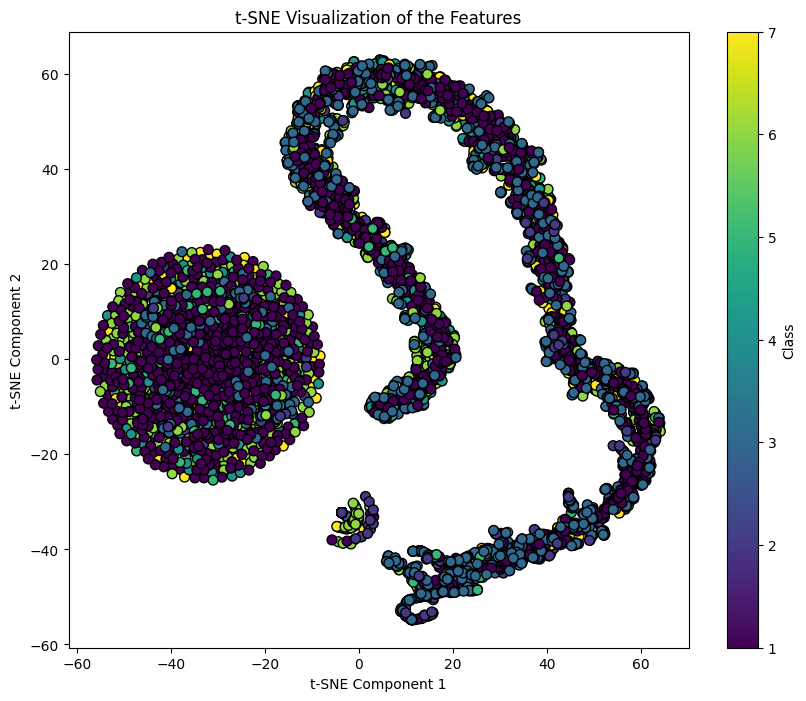

In [34]:
# Apply t-SNE for 2D Visualization (on PCA'ed)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_pca)
# Visualize the t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_labels, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='Class')
plt.title('t-SNE Visualization of the Features (PCA n_components = 1000)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Classification

In [35]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_pca, train_labels)  # Train on PCA-reduced features
clf.score(X_train_pca, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6806834706737761

In [36]:
# Evaluate on Validation Set
y_val_pred = clf.predict(X_val_pca)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

# Test the Classifier (evaluate on test data)
y_test_pred = clf.predict(X_test_pca)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Validation Set Performance:
              precision    recall  f1-score   support

           1       0.56      0.55      0.55      1204
           2       0.22      0.63      0.32       174
           3       0.20      0.19      0.19       364
           4       0.31      0.25      0.28       350
           5       0.06      0.06      0.06        98
           6       0.30      0.17      0.22       385
           7       0.03      0.02      0.02       203

    accuracy                           0.36      2778
   macro avg       0.24      0.27      0.24      2778
weighted avg       0.37      0.36      0.35      2778

Test Set Performance:
              precision    recall  f1-score   support

           1       0.60      0.57      0.59        77
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.50      0.32      0.39        34
           5       0.33      0.14      0.20         7
           6       0.25     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
